## ENCODE Jamboree Session 3: Locus Selection

This tutorial will introduce you to the data being used in this jamboree session, as well as some of the basic data analysis tools that we might use to perform locus selection. 

In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy
import pandas

from tqdm import tqdm_notebook as tqdm

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy

Tue Jan 08 2019 

numpy 1.14.2
scipy 1.0.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.15.0-42-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


First we need to load all of our data. We have 313 epigenomic experiments from K562. Each track is restricted to chromosome 22, and contains the arcsinh transformed -log10 p-values of the signal. The signal is arcisnh transformed to reduce the effect of outliers. The signal is at 25 bp resolution, so the first value in the array is the mean value across base pairs 1 through 25.

In [2]:
import glob

X, assays = numpy.zeros((2032739, 313), dtype='float32'), []
for i, filename in tqdm(enumerate(glob.glob('*.npz'))):
    X[:,i] = numpy.load(filename)['arr_0']
    
    assay = filename.split('.')[1]
    assay = assay.replace('ChIP-seq_', '').replace('_signal_p-value', '')
    assay = assay.replace('_strand_signal_of_all_reads', '')
    assay = assay.replace('_read-depth_normalized_signal', '')
    assays.append(assay)

A Jupyter Widget

Let's take a look at some of these assays in a small genomic region. We'll plot DNase accessibility as well as some common histone modifications, total RNA-seq, and some transcription factors.

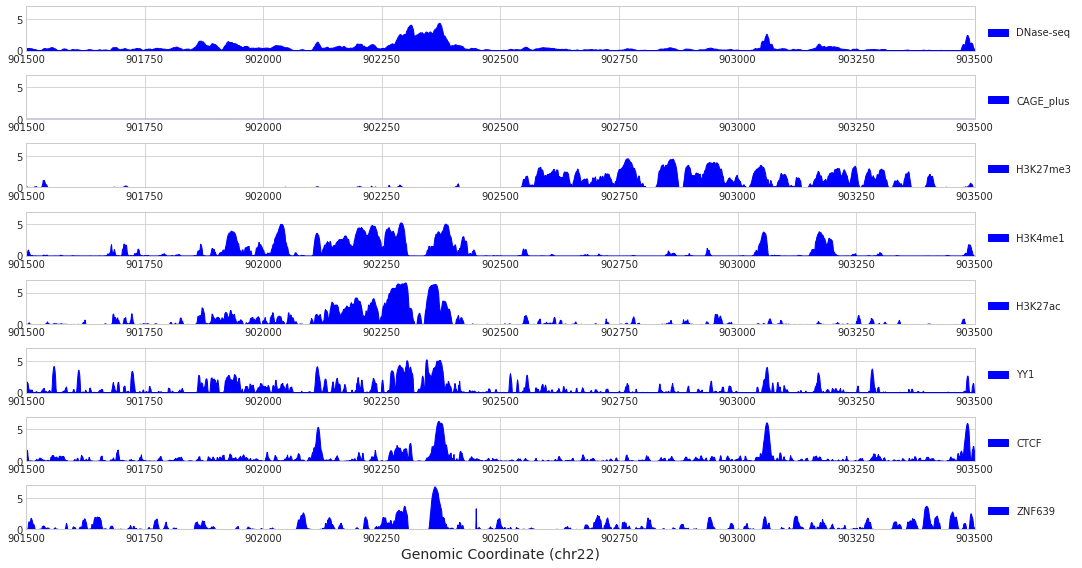

In [3]:
start, end = 901500, 903500
x = range(start, end)

assays_to_use = ["DNase-seq", "CAGE_plus", "H3K27me3", 
                 "H3K4me1", "H3K27ac", "YY1", "CTCF", "ZNF639"]

plt.figure(figsize=(14, 8))

for i, assay in enumerate(assays_to_use):
    plt.subplot(8, 1, i+1)
    plt.fill_between(x, 0, X[start:end, assays.index(assay)], color='b', label=assay)
    plt.xlim(start, end)
    plt.legend(fontsize=10, loc=(1.01, 0.2))
    plt.ylim(0, 7)
    
plt.xlabel("Genomic Coordinate (chr22)", fontsize=14)
plt.tight_layout()
plt.show()

It looks like this is a gene due to the RNA-seq signal and enrichment for enhancer marks.

### Supervised machine learning for enhancer finding

One approach we could use for the identification of cis-regulatory elements is supervised machine learning, where our positive labels come from verified cis-regulatory elements and negatives come from non-regulatory elements. Our predictions can then guide future characterization. Let's see a quick example that involves training a model to predict enhancers as defined by the FANTOM5 consortium.

In [4]:
enhancer_starts, enhancer_ends = [], []

y_enhancers = numpy.zeros(X.shape[0])

with open("hglft_genome_118c_3f6330.bed", "r") as infile:
    for line in infile:
        chrom, coords = line.split(":")
        start, end = coords.split('-')
        
        if chrom == 'chr22':
            y_enhancers[int(start)//25: int(end)//25 + 1] = 1

In [5]:
from sklearn.linear_model import LogisticRegression


X_train, y_enhancers_train = X[1200000:1400000], y_enhancers[1200000:1400000]
X_test, y_enhancers_test = X[800000:1000000], y_enhancers[800000:1000000]

model = LogisticRegression(solver='saga', class_weight='balanced')
model.fit(X_train, y_enhancers_train)

/home/jmschr/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

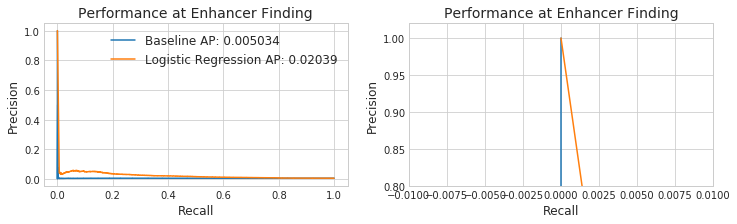

In [6]:
from sklearn.metrics import average_precision_score, precision_recall_curve

y_hat = model.predict_proba(X_test)[:,1]
y_rand = numpy.random.randn(y_hat.shape[0])

ap = average_precision_score(y_enhancers_test, y_hat)
ap_rand = average_precision_score(y_enhancers_test, y_rand)

precision, recall, _ = precision_recall_curve(y_enhancers_test, y_hat)
precision_r, recall_r, _ = precision_recall_curve(y_enhancers_test, y_rand)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(recall_r, precision_r, label="Baseline AP: {:4.4}".format(ap_rand))
plt.plot(recall, precision, label="Logistic Regression AP: {:4.4}".format(ap))
plt.title("Performance at Enhancer Finding", fontsize=14)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(fontsize=12)

plt.subplot(122)
plt.plot(recall_r, precision_r)
plt.plot(recall, precision)
plt.title("Performance at Enhancer Finding", fontsize=14)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(fontsize=12)

plt.xlim(-0.01, 0.01)
plt.ylim(0.8, 1.02)
plt.show()

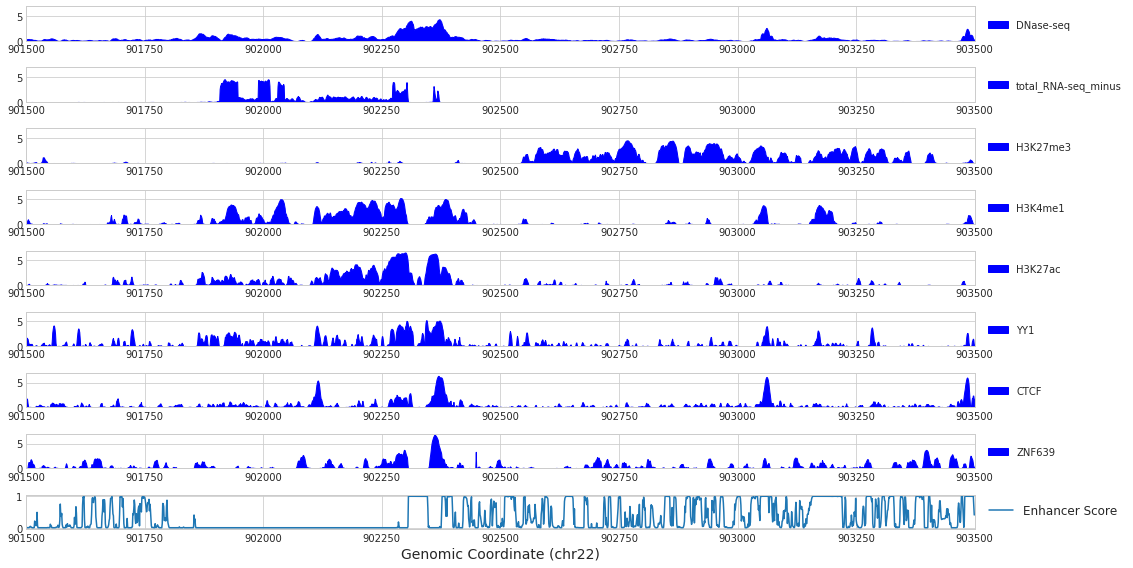

In [7]:
start, end = 901500, 903500
x = range(start, end)

assays_to_use = ["DNase-seq", "total_RNA-seq_minus", "H3K27me3", 
                 "H3K4me1", "H3K27ac", "YY1", "CTCF", "ZNF639"]

plt.figure(figsize=(14, 8))

for i, assay in enumerate(assays_to_use):
    plt.subplot(9, 1, i+1)
    plt.fill_between(x, 0, X[start:end, assays.index(assay)], color='b', label=assay)
    plt.xlim(start, end)
    plt.legend(fontsize=10, loc=(1.01, 0.2))
    plt.ylim(0, 7)
    

plt.subplot(9, 1, 9)
plt.plot(x, y_hat[start-800000:end-800000], label="Enhancer Score")
plt.xlim(start, end)
plt.legend(fontsize=12, loc=(1.01, 0.2))
    
plt.xlabel("Genomic Coordinate (chr22)", fontsize=14)
plt.tight_layout()
plt.show()

Unfortunately it looks like the model is predominantly only giving a high score whenever there is a peak in any of the functional elements. Interestingly, the model appears to learn that peaks in the RNA-seq assay preclude enhancer activity. A more sophisticated model would likely achieve higher precision, but still may be difficult to identify.

### Submodular selection for identifying a diverse set of loci

Submodular selection can be used to identify a diverse set of samples from a large collection. There has been a lot of work showing that these methods can be used to distill a large data set into a smaller one for use training machine learning models. In our case, we may want to select a diverse subset from all 25bp loci.

We can compare this approach to the supervised approach by using the learned ranking similarly to the output of a machine learning mode.

In [8]:
from apricot import FeatureBasedSelection

X_test = X_test.astype('float64')

model = FeatureBasedSelection(10000, verbose=True)
model.fit(X_test)

ranks = numpy.zeros(200000) - 10000
ranks[model.ranking] = numpy.arange(1, 10001)

100%|██████████| 10000/10000 [00:13<00:00, 766.22it/s]


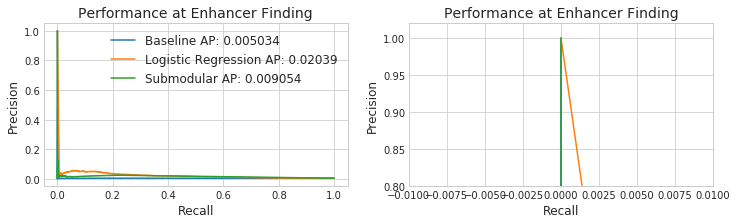

In [9]:
ap_submodular = average_precision_score(y_enhancers_test, ranks)
precision_s, recall_s, _ = precision_recall_curve(y_enhancers_test, ranks)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(recall_r, precision_r, label="Baseline AP: {:4.4}".format(ap_rand))
plt.plot(recall, precision, label="Logistic Regression AP: {:4.4}".format(ap))
plt.plot(recall_s, precision_s, label="Submodular AP: {:4.4}".format(ap_submodular))
plt.title("Performance at Enhancer Finding", fontsize=14)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(fontsize=12)

plt.subplot(122)
plt.plot(recall_r, precision_r)
plt.plot(recall, precision)
plt.plot(recall_s, precision_s)
plt.title("Performance at Enhancer Finding", fontsize=14)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(fontsize=12)

plt.xlim(-0.01, 0.01)
plt.ylim(0.8, 1.02)
plt.show()

We e some trends that we would expect. Namely, that the supervised machine learning model outperforms submodular selection at the task the model was trained on, but that submodular selection outperforms our baseline.